# Notebook 9.1 - Metaheuristics: Beyond Local Optima

Management Science - Bean Counter’s European Expansion

# Introduction

Welcome back, CEO! Bean Counter has grown to **1,000 cafés across
Europe**, and the Board just dropped a bombshell in your quarterly
review:

**The Distribution Crisis:**

-   Current network: 50 distribution centers selected **randomly** 10
    years ago
-   Annual logistics cost: **€45 million** (facility leases + delivery)
-   Competitors using optimization are **20% more efficient**
-   Board mandate: **Redesign the entire network** or lose market share

You have 200 potential locations to choose from, and must select exactly
50 for new 10-year leases starting next quarter.

**Your mission:** Use advanced optimization to save **€10+ million
annually** and prove that Bean Counter can compete in the age of AI.

> **The Stakes Are High**
>
> This is NOT a routing problem with a few trucks. This is a **strategic
> infrastructure decision** worth millions over the contract period.
> Simple methods will find *good* solutions. But metaheuristics can
> potentially find **great** solutions worth millions more.

> **How to Use This Tutorial**
>
> Work through each section in order. Write code where marked “YOUR CODE
> BELOW” and verify with the provided assertions. You’ll implement
> greedy, local search, simulated annealing, and genetic algorithms, the
> techniques you’ll need for the Restaurant Staffing Competition!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple, Set
import random
import math

# Set random seed for reproducibility
np.random.seed(2025)
random.seed(2025)

print("Libraries loaded! Let's optimize Bean Counter's European distribution network.")

Libraries loaded! Let's optimize Bean Counter's European distribution network.

# Section 1: Understanding the Distribution Network

Before we can optimize, we need to understand the scale and structure of
Bean Counter’s challenge.

## Bean Counter’s European Footprint

In [2]:
# DON'T CHANGE ANYTHING BELOW
# Major European cities (simplified)
european_cities = {
    'London': (51.5074, -0.1278, 120),
    'Paris': (48.8566, 2.3522, 95),
    'Berlin': (52.5200, 13.4050, 80),
    'Madrid': (40.4168, -3.7038, 75),
    'Rome': (41.9028, 12.4964, 65),
    'Amsterdam': (52.3676, 4.9041, 55),
    'Vienna': (48.2082, 16.3738, 50),
    'Barcelona': (41.3851, 2.1734, 60),
    'Munich': (48.1351, 11.5820, 45),
    'Hamburg': (53.5511, 9.9937, 40),
    'Milan': (45.4642, 9.1900, 55),
    'Prague': (50.0755, 14.4378, 35),
    'Brussels': (50.8503, 4.3517, 45),
    'Zurich': (47.3769, 8.5417, 40),
    'Copenhagen': (55.6761, 12.5683, 35),
    'Stockholm': (59.3293, 18.0686, 38),
    'Dublin': (53.3498, -6.2603, 32),
    'Lyon': (45.7640, 4.8357, 30),
    'Manchester': (53.4808, -2.2426, 28),
    'Lisbon': (38.7223, -9.1393, 42)
}

def generate_cafe_locations(cities_dict, total_cafes=1000):
    """Generate café locations clustered around major European cities."""
    cafes = []
    cities_list = list(cities_dict.items())

    # Distribute cafés proportionally to city size
    total_weight = sum(weight for _, (_, _, weight) in cities_list)

    for city_name, (lat, lon, weight) in cities_list:
        # Number of cafés in this city's region
        n_cafes = int(total_cafes * weight / total_weight)

        # Generate cafés with some spread around city center
        for _ in range(n_cafes):
            # Add random offset
            cafe_lat = lat + np.random.normal(0, 1.2)
            cafe_lon = lon + np.random.normal(0, 1.4)
            cafes.append((cafe_lat, cafe_lon))

    # Fill remaining cafés to reach exactly 1000
    while len(cafes) < total_cafes:
        city_name, (lat, lon, _) = random.choice(cities_list)
        cafe_lat = lat + np.random.normal(0, 0.7)
        cafe_lon = lon + np.random.normal(0, 0.7)
        cafes.append((cafe_lat, cafe_lon))

    return cafes[:total_cafes]

# Generate café locations
cafe_locations = generate_cafe_locations(european_cities)

# Generate potential distribution center locations
# (More concentrated near major cities, but with some strategic outliers)
potential_centers = []
cities_list = list(european_cities.items())

for city_name, (lat, lon, weight) in cities_list:
    # More centers near bigger cities
    n_centers = max(5, int(200 * weight / sum(w for _, (_, _, w) in cities_list)))

    for _ in range(min(n_centers, 15)):  # Cap per city
        center_lat = lat + np.random.normal(0, 2.0)
        center_lon = lon + np.random.normal(0, 2.0)
        potential_centers.append((center_lat, center_lon))

# Ensure exactly 200 potential centers
while len(potential_centers) < 200:
    city_name, (lat, lon, _) = random.choice(cities_list)
    center_lat = lat + np.random.normal(0, 0.7)
    center_lon = lon + np.random.normal(0, 0.7)
    potential_centers.append((center_lat, center_lon))

potential_centers = potential_centers[:200]

print(f"Bean Counter's European Network:")
print(f"  • {len(cafe_locations)} cafés requiring daily deliveries")
print(f"  • {len(potential_centers)} potential distribution center locations")
print(f"  • Must select exactly 50 centers for 10-year lease")
print(f"  • Each center: €500,000/year facility cost")
print(f"  • Each center serves exactly 20 cafés (balanced load)")
print(f"  • Delivery cost: €2 per km per day")
print(f"\nTotal annual facility budget: €25,000,000")
print("Delivery costs depend on your network design!")
# DON'T CHANGE ANYTHING ABOVE

Bean Counter's European Network:
  • 1000 cafés requiring daily deliveries
  • 200 potential distribution center locations
  • Must select exactly 50 centers for 10-year lease
  • Each center: €500,000/year facility cost
  • Each center serves exactly 20 cafés (balanced load)
  • Delivery cost: €2 per km per day

Total annual facility budget: €25,000,000
Delivery costs depend on your network design!

## Visualizing the Network

Let’s see the geographic distribution of cafés and potential centers
across Europe:

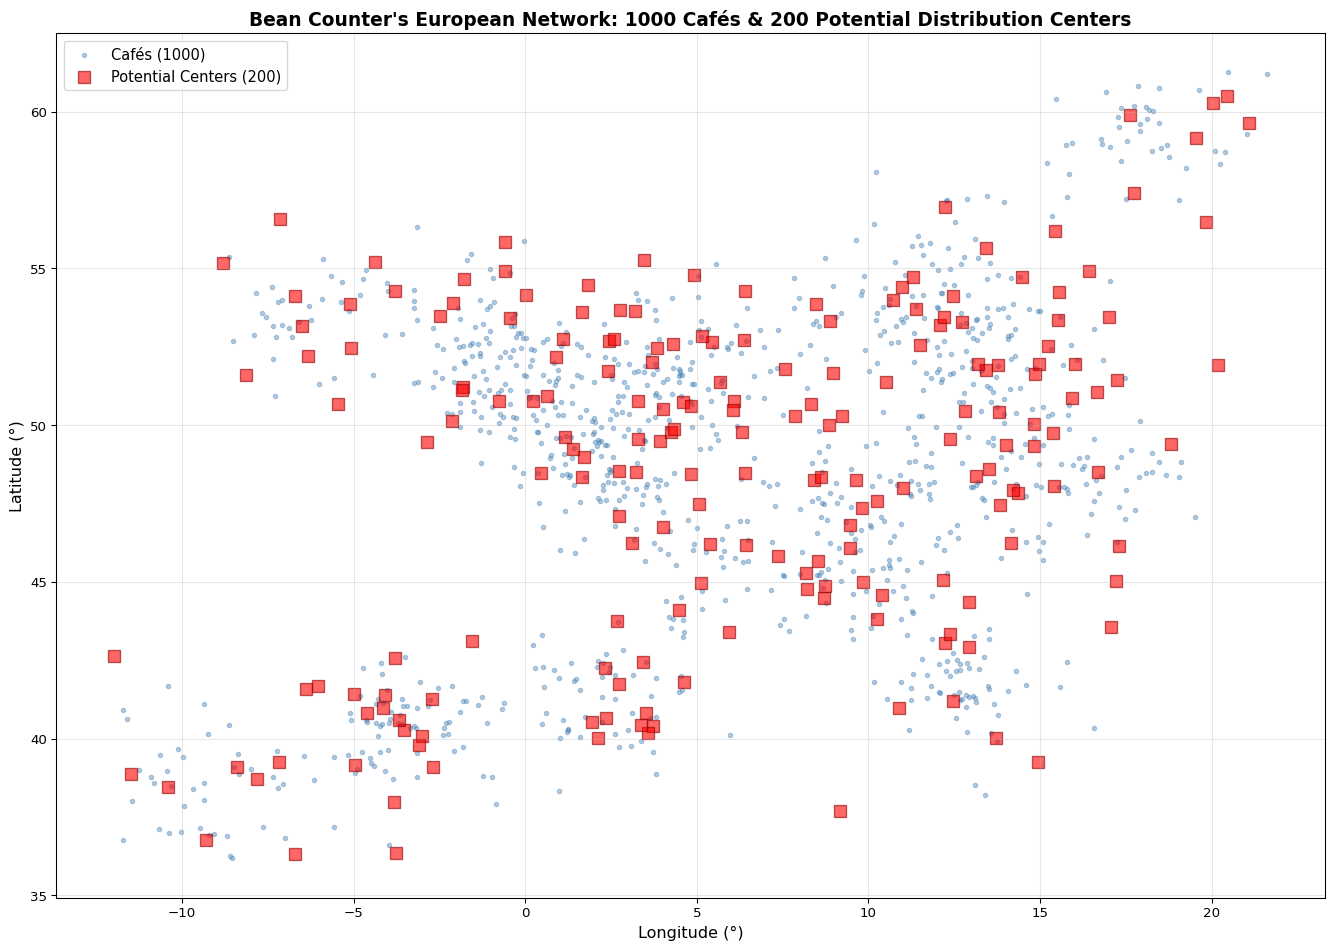

In [3]:
# Create visualization of Bean Counter's European network
plt.figure(figsize=(14, 10))

# Plot cafés
cafe_lats = [loc[0] for loc in cafe_locations]
cafe_lons = [loc[1] for loc in cafe_locations]
plt.scatter(cafe_lons, cafe_lats, s=10, alpha=0.4, color='steelblue', label='Cafés (1000)')

# Plot potential centers
center_lats = [loc[0] for loc in potential_centers]
center_lons = [loc[1] for loc in potential_centers]
plt.scatter(center_lons, center_lats, s=80, alpha=0.6, color='red',
           marker='s', label='Potential Centers (200)', edgecolors='darkred', linewidth=1)

plt.xlabel('Longitude (°)', fontsize=12)
plt.ylabel('Latitude (°)', fontsize=12)
plt.title("Bean Counter's European Network: 1000 Cafés & 200 Potential Distribution Centers",
         fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Notice how cafés cluster around major European cities! This will be
important for our optimization.

## Calculating Geographic Distances

We’ll use the Haversine formula to calculate real distances between
geographic coordinates.

> **The Haversine Formula**
>
> For geographic coordinates (latitude, longitude), we can’t use simple
> Euclidean distance because Earth is a sphere!
>
> The **Haversine formula** calculates great-circle distance:
>
> $$d = 2r \arcsin\left(\sqrt{\sin^2\left(\frac{\Delta\phi}{2}\right) + \cos(\phi_1)\cos(\phi_2)\sin^2\left(\frac{\Delta\lambda}{2}\right)}\right)$$
>
> Where:
>
> -   $r$ = Earth’s radius (≈ 6371 km)
> -   $\phi$ = latitude in radians
> -   $\lambda$ = longitude in radians

Here it is already implemented, you just need to call it:

In [4]:
def haversine_distance(loc1: Tuple[float, float], loc2: Tuple[float, float]) -> float:
    """Calculate distance in km between two (lat, lon) points using Haversine formula."""
    lat1, lon1 = loc1
    lat2, lon2 = loc2

    # Convert to radians
    lat1_rad = math.radians(lat1)
    lat2_rad = math.radians(lat2)
    lon1_rad = math.radians(lon1)
    lon2_rad = math.radians(lon2)

    # Differences
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Haversine formula
    a = math.sin(dlat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))

    R = 6371  # Earth's radius in km

    return R * c

# Test the distance function
test_dist = haversine_distance((51.5074, -0.1278), (48.8566, 2.3522))  # London to Paris
print(f"Example: London to Paris = {test_dist:.1f} km")

test_dist2 = haversine_distance((52.5200, 13.4050), (48.2082, 16.3738))  # Berlin to Vienna
print(f"Example: Berlin to Vienna = {test_dist2:.1f} km")

Example: London to Paris = 343.6 km
Example: Berlin to Vienna = 523.5 km

Great! Now we can calculate real distances between any two locations in
Europe.

## Exercise 1.1: Implement the Network Cost Function with Balanced Allocation

This is the **heart** of the optimization, the function that determines
if a network design is good or bad.

> **Working with Sets in Python**
>
> A **set** is an unordered collection with no duplicates:
>
> ``` python
> unassigned = {1, 2, 3, 4, 5}
> unassigned.remove(3)      # Remove element (error if not found)
> len(unassigned)           # Number of elements
> 3 in unassigned           # Check membership (fast!)
> ```
>
> **Why use sets here?** Fast membership testing and removal. Perfect
> for tracking which cafés still need assignment!

> **Balanced Allocation Strategy**
>
> **Key Innovation**: Each center gets exactly 20 cafés (1000 ÷ 50 = 20)
>
> **Greedy Assignment Process**:
>
> 1.  For each selected center:
>     -   Find the 20 nearest unassigned cafés
>     -   Assign them to this center
>     -   Mark them as assigned
> 2.  Sum up all delivery distances
> 3.  Calculate total cost
>
> **Why this is better**:
>
> -   **Always feasible** - balanced load by construction
> -   **No capacity violations** - each center gets exactly 20 cafés
> -   **Realistic** - distribution territories are typically balanced
> -   **Simple** - no penalty functions or feasibility checks needed

> **Before You Start**
>
> Here’s the implementation plan:
>
> 1.  **Loop through each selected center** to assign its 20 cafés
> 2.  **For each center**, calculate distances to ALL unassigned cafés
>     using `haversine_distance`
> 3.  **Store results as tuples**:
>     `[(distance1, cafe_idx1), (distance2, cafe_idx2), ...]`
> 4.  **Sort the list** by distance using `.sort()` (smallest first)
> 5.  **Take the first 20** using list slicing `[:cafes_per_center]`
> 6.  **Add distances to total** and remove assigned cafés from the
>     `unassigned_cafes` set
>
> **Hint**: Loop `for cafe_idx in unassigned_cafes:` to build the
> distance list!

In [5]:
def calculate_network_cost(selected_centers: List[int],
                          cafe_locs: List[Tuple[float, float]],
                          center_locs: List[Tuple[float, float]],
                          cafes_per_center: int = 20) -> float:
    """
    Calculate total annual cost using balanced greedy allocation.

    Args:
        selected_centers: List of indices (0-199) of selected centers
        cafe_locs: List of (lat, lon) tuples for cafés
        center_locs: List of (lat, lon) tuples for potential centers
        cafes_per_center: Number of cafés each center serves (default 20)

    Returns:
        total_cost: Total annual cost in €
    """
    # Fixed facility cost
    facility_cost = 500_000 * len(selected_centers)

    # Track which cafés have been assigned
    unassigned_cafes = set(range(len(cafe_locs)))
    total_daily_distance = 0

    # Greedily assign cafés to each center
    for center_idx in selected_centers:
        center_loc = center_locs[center_idx]

        # Step 1: Calculate distances from this center to all unassigned cafés
        distances_to_unassigned = []
        for cafe_idx in unassigned_cafes:
            distance = # YOUR CODE - calculate distance using haversine_distance
            distances_to_unassigned.append((distance, cafe_idx))

        # Step 2: Sort by distance and take the nearest cafes_per_center cafés
        distances_to_unassigned.sort()
        nearest_cafes = distances_to_unassigned[:cafes_per_center]

        # Step 3: Add their distances to the total and mark as assigned
        for distance, cafe_idx in nearest_cafes:
            total_daily_distance += distance
            unassigned_cafes.remove(cafe_idx)

    # Delivery cost: €2/km/day × 365 days
    delivery_cost = total_daily_distance * 2 * 365

    total_cost = facility_cost + delivery_cost

    return total_cost

In [7]:
# Test your cost function with a random network
test_centers = random.sample(range(200), 50)
test_cost = calculate_network_cost(test_centers, cafe_locations, potential_centers)

assert test_cost > 25_000_000, "Cost should be > facility cost alone"
assert test_cost < 300_000_000, f"Cost seems too high: €{test_cost:,.0f}"

print("Cost function working!")
print(f"Random network cost: €{test_cost:,.0f}")
print(f"  Facility cost: €25,000,000")
print(f"  Delivery cost: €{test_cost - 25_000_000:,.0f}")
print(f"Note: Each center serves exactly 20 cafés - always balanced and feasible!")

## Helper Function: Get Café-Center Assignments

No need to do anything here, we’ll use this function to determine which
cafés are assigned to which centers for visualization:

In [8]:
def get_cafe_assignments(selected_centers: List[int],
                         cafe_locs: List[Tuple[float, float]],
                         center_locs: List[Tuple[float, float]],
                         cafes_per_center: int = 20) -> dict:
    """
    Get the assignment of cafés to centers using the same greedy allocation as the cost function.
    
    Returns:
        Dictionary mapping center_idx -> list of assigned café indices
    """
    unassigned_cafes = set(range(len(cafe_locs)))
    assignments = {}
    
    for center_idx in selected_centers:
        center_loc = center_locs[center_idx]
        
        # Calculate distances from this center to all unassigned cafés
        distances_to_unassigned = []
        for cafe_idx in unassigned_cafes:
            distance = haversine_distance(center_loc, cafe_locs[cafe_idx])
            distances_to_unassigned.append((distance, cafe_idx))
        
        # Sort by distance and take the nearest cafes_per_center cafés
        distances_to_unassigned.sort()
        nearest_cafes = distances_to_unassigned[:cafes_per_center]
        
        # Record assignments
        assignments[center_idx] = [cafe_idx for _, cafe_idx in nearest_cafes]
        
        # Mark as assigned
        for _, cafe_idx in nearest_cafes:
            unassigned_cafes.remove(cafe_idx)
    
    return assignments

## Visualize Initial Random Solution

Let’s see what our random baseline looks like with connection lines:

In [9]:
# Visualize the initial random solution
plt.figure(figsize=(14, 10))

# Get assignments for the random solution
random_assignments = get_cafe_assignments(test_centers, cafe_locations, potential_centers)

# Plot connection lines first (so they appear behind markers)
for center_idx, cafe_indices in random_assignments.items():
    center_loc = potential_centers[center_idx]
    for cafe_idx in cafe_indices:
        cafe_loc = cafe_locations[cafe_idx]
        plt.plot([center_loc[1], cafe_loc[1]], [center_loc[0], cafe_loc[0]], 
                'gray', alpha=0.3, linewidth=1.5, zorder=1)
        
# Plot all locations        
plt.scatter(center_lons, center_lats, s=80, alpha=0.1, color='red',
           marker='s', label='Potential Centers (200)', edgecolors='darkred', linewidth=1)

# Plot cafés
cafe_lats = [loc[0] for loc in cafe_locations]
cafe_lons = [loc[1] for loc in cafe_locations]
plt.scatter(cafe_lons, cafe_lats, s=8, alpha=0.6, color='steelblue', 
           label='Cafés (1000)', zorder=2)

# Plot selected centers
selected_lats = [potential_centers[i][0] for i in test_centers]
selected_lons = [potential_centers[i][1] for i in test_centers]
plt.scatter(selected_lons, selected_lats, s=150, alpha=1.0, color='red',
           marker='*', label='Random Centers (50)', edgecolors='darkred', 
           linewidth=2, zorder=3)

plt.xlabel('Longitude (°)', fontsize=12)
plt.ylabel('Latitude (°)', fontsize=12)
plt.title(f'Initial Random Solution: €{test_cost:,.0f}/year\n(Each line connects a café to its distribution center)',
         fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

baseline_random_cost = test_cost  # Save for comparison

# Section 2: Greedy Construction - The Baseline

Let’s start with the simplest approach: pick the 50 centers that
minimize total distance to cafés.

> **Greedy Algorithm Strategy**
>
> At each step, pick the center that gives the **biggest immediate
> benefit**:
>
> 1.  Start with empty selection
> 2.  For each of 50 iterations:
>     -   Try adding each remaining center
>     -   Calculate the cost with balanced allocation
>     -   Add the center with the lowest cost
> 3.  Return final selection
>
> **Note**: With balanced allocation, every solution is automatically
> feasible!

## Exercise 2.1: Implement Greedy Center Selection

> **Before You Start**
>
> The greedy algorithm picks centers one at a time, always choosing the
> best addition:
>
> 1.  **Loop 50 times** (one for each center to select)
> 2.  **For each candidate** in the remaining centers:
>     -   Create `temp_selection = selected + [candidate]`
>     -   Calculate the cost if we selected this candidate
>     -   Track the candidate with the lowest cost
> 3.  **Add the best candidate** to `selected` and remove from
>     `remaining`
>
> **Key insight**: This is expensive (trying ~150 centers × 50 times =
> 7,500 cost calculations), but it builds a good initial solution!

In [10]:
def greedy_center_selection(cafe_locs: List[Tuple[float, float]],
                           center_locs: List[Tuple[float, float]],
                           n_select: int = 50) -> List[int]:
    """
    Select distribution centers using greedy algorithm.

    Args:
        cafe_locs: Café locations
        center_locs: Potential center locations
        n_select: Number of centers to select

    Returns:
        List of selected center indices
    """
    selected = []
    remaining = set(range(len(center_locs)))

    print(f"Greedy selection: Selecting {n_select} centers...")

    for step in range(n_select):
        best_center = None
        best_cost = float('inf')

        # Step 1: Try adding each remaining center
        for candidate in remaining:
            # Step 2: Create temporary selection with this candidate added
            temp_selection = selected + [candidate]

            # Step 3: Calculate cost with balanced allocation
            cost = # YOUR CODE - use calculate_network_cost

            # Step 4: Track if this is the best so far
            if cost < best_cost:
                best_cost = # YOUR CODE
                best_center = # YOUR CODE

        # Add the best center found
        selected.append(best_center)
        remaining.remove(best_center)

        if (step + 1) % 10 == 0:
            print(f"  Selected {step + 1}/{n_select} centers, current cost: €{best_cost:,.0f}")

    return selected

In [12]:
# Run greedy algorithm
greedy_solution = greedy_center_selection(cafe_locations, potential_centers, 50)
greedy_cost = calculate_network_cost(greedy_solution, cafe_locations, potential_centers)

In [13]:
# Test greedy solution
assert len(greedy_solution) == 50, "Should select exactly 50 centers"
assert len(set(greedy_solution)) == 50, "Should not select duplicates"
assert greedy_cost < test_cost, f"Greedy should beat random baseline, got €{greedy_cost:,.0f}"

baseline_random_cost = test_cost  # Historical random selection
greedy_savings = baseline_random_cost - greedy_cost
greedy_improvement_pct = (greedy_savings / baseline_random_cost) * 100

print(f"Greedy algorithm complete!")
print(f"Greedy network cost: €{greedy_cost:,.0f}")
print(f"vs. Current random network: €{baseline_random_cost:,.0f}")
print(f"Annual savings: €{greedy_savings:,.0f} ({greedy_improvement_pct:.1f}% improvement)")

## Visualize the Greedy Solution

In [14]:
plt.figure(figsize=(14, 10))

# Get assignments for the greedy solution
greedy_assignments = get_cafe_assignments(greedy_solution, cafe_locations, potential_centers)

# Plot connection lines first (so they appear behind markers)
for center_idx, cafe_indices in greedy_assignments.items():
    center_loc = potential_centers[center_idx]
    for cafe_idx in cafe_indices:
        cafe_loc = cafe_locations[cafe_idx]
        plt.plot([center_loc[1], cafe_loc[1]], [center_loc[0], cafe_loc[0]], 
                'blue', alpha=0.3, linewidth=1.5, zorder=1)

# Plot all locations        
plt.scatter(center_lons, center_lats, s=80, alpha=0.1, color='red',
           marker='s', label='Potential Centers (200)', edgecolors='darkred', linewidth=1)

# Plot all cafés
plt.scatter(cafe_lons, cafe_lats, s=8, alpha=0.6, color='steelblue', 
           label='Cafés', zorder=2)

# Plot unselected centers
unselected = [i for i in range(200) if i not in greedy_solution]
unselected_lats = [potential_centers[i][0] for i in unselected]
unselected_lons = [potential_centers[i][1] for i in unselected]
plt.scatter(unselected_lons, unselected_lats, s=40, alpha=0.2, color='gray',
           marker='s', label='Unselected Centers', zorder=2)

# Plot selected centers
selected_lats = [potential_centers[i][0] for i in greedy_solution]
selected_lons = [potential_centers[i][1] for i in greedy_solution]
plt.scatter(selected_lons, selected_lats, s=150, alpha=1.0, color='blue',
           marker='*', label='Greedy Selected (50)', edgecolors='black', 
           linewidth=1, zorder=3)

plt.xlabel('Longitude (°)', fontsize=12)
plt.ylabel('Latitude (°)', fontsize=12)
plt.title(f'Greedy Solution: €{greedy_cost:,.0f}/year ({greedy_improvement_pct:.1f}% improvement)\n(Blue lines show café-to-center assignments)',
         fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

> **The Greedy Trap**
>
> Greedy saved us some money! But greedy algorithms are
> **short-sighted**:
>
> -   They make locally optimal choices
> -   They never reconsider earlier decisions
> -   They can’t escape suboptimal patterns
>
> **Can we do better?**

# Section 3: Local Search

Remember **2-opt swaps** from the routing notebook? There, we improved
routes by reversing segments. Here, we’ll use the **same local search
philosophy** but with a different neighborhood:

**Routing:** Swap edges in a route (reverse a segment)  
**Distribution Network:** Swap centers in/out of the selection

The core idea remains: **make small changes, keep improvements, stop at
local optimum**.

> **Local Search**
>
> **Core idea**: Start with a solution, repeatedly make small changes
> that improve it.
>
> **The local search pattern**:
>
> 1.  Start with current solution
> 2.  Generate a **neighbor** (slightly different solution)
> 3.  If neighbor is better, keep it
> 4.  Repeat until no improvement found
>
> **Problem**: Gets stuck in **local optima** (can’t improve further,
> but not the global best)

## Exercise 3.1: Implement the Swap Neighborhood

Create a neighbor by swapping one selected center with one unselected
center.

> **List Comprehensions for Filtering**
>
> Create new lists based on conditions in one line:
>
> ``` python
> # Traditional approach
> unselected = []
> for i in range(200):
>     if i not in current_selection:
>         unselected.append(i)
>
> # List comprehension (same result, cleaner!)
> unselected = [i for i in range(200) if i not in current_selection]
> ```
>
> **Pattern:** `[expression for item in iterable if condition]`
>
> This is perfect for finding which centers are NOT currently selected!

> **Before You Start**
>
> Your implementation steps:
>
> 1.  **Find unselected centers**:
>     `[i for i in range(n_centers) if i not in current_selection]`
> 2.  **Pick a random position** to remove from current_selection:
>     `random.randint(0, len(current_selection) - 1)`
> 3.  **Pick a random center** to add: `random.choice(unselected)`
> 4.  **Create a copy** of current_selection and replace the element at
>     the random index with the new center
>
> **Hint**: Use `.copy()` to avoid modifying the original list!

In [15]:
def generate_swap_neighbor(current_selection: List[int],
                          n_centers: int = 200) -> List[int]:
    """
    Generate a neighbor by swapping one selected center with one unselected.

    Args:
        current_selection: Current list of selected centers
        n_centers: Total number of potential centers

    Returns:
        New selection with one center swapped
    """
    
    # Get unselected centers
    unselected = [i for i in range(n_centers) if i not in current_selection]

    # Pick random indices
    remove_idx = random.randint(0, len(current_selection) - 1)
    add_center = random.choice(unselected)

    # Create new selection
    new_selection = current_selection.copy()
    # YOUR CODE: remove and add based on indices

    return new_selection

In [17]:
# Test swap function
test_neighbor = generate_swap_neighbor(greedy_solution)
assert len(test_neighbor) == 50, "Neighbor should have 50 centers"
assert len(set(test_neighbor)) == 50, "No duplicates"
assert len(set(test_neighbor) & set(greedy_solution)) == 49, "Should differ by exactly 1 center"

print("1-opt neighbor generation working!")
print(f"Changed 1 center from the solution")

## Exercise 3.2: Implement Local Search

Now implement the full local search algorithm.

> **Before You Start**
>
> Local search repeatedly tries to improve the current solution:
>
> 1.  **Try multiple neighbors** each iteration (parameter:
>     `neighbors_per_iteration`)
> 2.  **For each neighbor**:
>     -   Generate it using `generate_swap_neighbor(current)`
>     -   Calculate its cost using `calculate_network_cost(...)`
>     -   If better than current, **accept it immediately** and break
>         the inner loop
> 3.  **Track improvements**: Increment counter when you accept a
>     neighbor
> 4.  **Stop when stuck**: If you try all neighbors and none improve,
>     you’ve reached a local optimum
>
> **Key difference from greedy**: Greedy builds from scratch; local
> search improves an existing solution!

In [18]:
def local_search(initial_solution: List[int],
                cafe_locs: List[Tuple[float, float]],
                center_locs: List[Tuple[float, float]],
                max_iterations: int = 1000,
                neighbors_per_iteration: int = 20) -> Tuple[List[int], float, int]:
    """
    Improve a solution using local search.

    Args:
        initial_solution: Starting selection of centers
        cafe_locs: Café locations
        center_locs: Center locations
        max_iterations: Maximum improvement iterations
        neighbors_per_iteration: How many neighbors to try each iteration

    Returns:
        (best_solution, best_cost, num_improvements)
    """
    current = initial_solution.copy()
    current_cost = calculate_network_cost(current, cafe_locs, center_locs)

    improvements = 0

    print("Local search starting...")

    for iteration in range(max_iterations):
        improved = False

        # Step 1: Try multiple neighbors per iteration
        for _ in range(neighbors_per_iteration):
            # Step 2: Generate neighbor
            neighbor = # YOUR CODE - use generate_swap_neighbor

            # Step 3: Evaluate neighbor
            neighbor_cost = # YOUR CODE - use calculate_network_cost

            # Step 4: If better, keep it and break inner loop
            if neighbor_cost < current_cost:
                current = # YOUR CODE
                current_cost = # YOUR CODE
                improvements += 1
                improved = True
                break

        if improved and (improvements % 5 == 0):
            print(f"  Iteration {iteration}: {improvements} improvements, cost: €{current_cost:,.0f}")

        if not improved:
            print(f"Local optimum reached after {iteration} iterations")
            break

    return current, current_cost, improvements

In [20]:
# Run local search from greedy solution
ls_solution, ls_cost, ls_improvements = local_search(greedy_solution, cafe_locations, potential_centers)

In [21]:
# Test local search
assert ls_cost <= greedy_cost, "Local search shouldn't make solution worse"
assert ls_improvements >= 0, "Should track improvements"

ls_savings = baseline_random_cost - ls_cost
ls_improvement_pct = (ls_savings / baseline_random_cost) * 100

print(f"Local search complete!")
print(f"Local search cost: €{ls_cost:,.0f}")
print(f"vs. Greedy: €{greedy_cost:,.0f}")
print(f"Additional savings: €{greedy_cost - ls_cost:,.0f}")
print(f"Total vs. baseline: €{ls_savings:,.0f} ({ls_improvement_pct:.1f}% improvement)")
print(f"Number of swaps: {ls_improvements}")

## Visualize Local Search Solution

In [22]:
plt.figure(figsize=(14, 10))

# Get assignments for the local search solution
ls_assignments = get_cafe_assignments(ls_solution, cafe_locations, potential_centers)

# Plot connection lines first (so they appear behind markers)
for center_idx, cafe_indices in ls_assignments.items():
    center_loc = potential_centers[center_idx]
    for cafe_idx in cafe_indices:
        cafe_loc = cafe_locations[cafe_idx]
        plt.plot([center_loc[1], cafe_loc[1]], [center_loc[0], cafe_loc[0]], 
                'mediumseagreen', alpha=0.3, linewidth=1.5, zorder=1)
        
# Plot all locations        
plt.scatter(center_lons, center_lats, s=80, alpha=0.1, color='red',
           marker='s', label='Potential Centers (200)', edgecolors='darkred', linewidth=1)

# Plot all cafés
plt.scatter(cafe_lons, cafe_lats, s=8, alpha=0.6, color='steelblue', 
           label='Cafés', zorder=2)

# Plot selected centers
selected_lats = [potential_centers[i][0] for i in ls_solution]
selected_lons = [potential_centers[i][1] for i in ls_solution]
plt.scatter(selected_lons, selected_lats, s=150, alpha=1.0, color='mediumseagreen',
           marker='*', label='Local Search Selected (50)', edgecolors='darkgreen', 
           linewidth=1, zorder=3)

plt.xlabel('Longitude (°)', fontsize=12)
plt.ylabel('Latitude (°)', fontsize=12)
plt.title(f'Local Search Solution: €{ls_cost:,.0f}/year ({ls_improvement_pct:.1f}% improvement)\n(Improved from Greedy by {ls_improvements} swaps)',
         fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

> **The Local Optimum Problem**
>
> Local search potentially finds a better solution than greedy, but this
> is not always the case as it can easily be **stuck at a local
> optimum**:
>
> -   No single swap improves the solution
> -   But a **sequence** of swaps (including temporary bad moves) might
>     lead somewhere better
> -   Like hiking: sometimes you must go downhill briefly to reach a
>     higher peak
>
> **This is why we need metaheuristics!**

# Section 4: Simulated Annealing - Escaping Local Optima

Simulated Annealing (SA) is inspired by metallurgy: heating metal allows
atoms to escape local patterns and find better arrangements as it cools.

## Exercise 4.1: Implement the SA Acceptance Criterion

> **Before You Start**
>
> Idea: Sometimes accept **worse** solutions to escape local optima!
>
> Implementation is straightforward:
>
> 1.  **If improvement** (new_cost \< current_cost): Always return
>     `True`
> 2.  **If worse** (new_cost \>= current_cost):
>     -   Calculate `delta = new_cost - current_cost`
>     -   Calculate `probability = math.exp(-delta / temperature)`
>     -   Return `True` with that probability:
>         `random.random() < probability`
>
> **Key insight**: As temperature decreases, probability → 0, so SA
> becomes greedy!

> **Acceptance Probability - Concrete Examples**
>
> **Scenario 1: Small cost increase, high temperature**
>
> -   Current: €40,000,000
> -   Neighbor: €40,100,000 (€100K worse)
> -   Temperature: T = 1,000,000
> -   Delta = 100,000
> -   Probability = exp(-100,000 / 1,000,000) = exp(-0.1) ≈ **90.5%** →
>     Often accept!
>
> **Scenario 2: Same increase, low temperature**
>
> -   Current: €40,000,000
> -   Neighbor: €40,100,000 (€100K worse)
> -   Temperature: T = 1,000
> -   Delta = 100,000
> -   Probability = exp(-100,000 / 1,000) = exp(-100) ≈ **0.0%** →
>     Reject!
>
> **Scenario 3: Large increase, high temperature**
>
> -   Current: €40,000,000
> -   Neighbor: €42,000,000 (€2M worse!)
> -   Temperature: T = 1,000,000
> -   Delta = 2,000,000
> -   Probability = exp(-2,000,000 / 1,000,000) = exp(-2) ≈ **13.5%** →
>     Sometimes accept!
>
> **The pattern**: Higher temperature → more exploration. Lower
> temperature → more exploitation.

In [23]:
def accept_move(current_cost: float, new_cost: float, temperature: float) -> bool:
    """
    Decide whether to accept a move in simulated annealing.

    Args:
        current_cost: Current solution cost
        new_cost: Candidate solution cost
        temperature: Current temperature

    Returns:
        True if move should be accepted
    """
    if new_cost < current_cost:
        return True  # Always accept improvements
    else:
        # Calculate acceptance probability
        delta = # YOUR CODE
        probability = # YOUR CODE

        return random.random() < probability

In [25]:
# Test acceptance function
# At high temp, should accept worse moves frequently
high_temp_accepts = sum(accept_move(1000, 1100, temperature=500) for _ in range(1000))
assert high_temp_accepts > 300, f"High temp should accept ~60% of moves, got {high_temp_accepts/10}%"

# At low temp, should reject worse moves
low_temp_accepts = sum(accept_move(1000, 1100, temperature=10) for _ in range(1000))
assert low_temp_accepts < 200, f"Low temp should accept <20% of moves, got {low_temp_accepts/10}%"

# Always accept improvements
improvements = sum(accept_move(1000, 900, temperature=100) for _ in range(100))
assert improvements == 100, "Should always accept improvements"

print("Acceptance criterion working!")
print(f"High temp (T=500): {high_temp_accepts/10:.1f}% acceptance for +€100 move")
print(f"Low temp (T=10): {low_temp_accepts/10:.1f}% acceptance for +€100 move")

## Exercise 4.2: Implement Simulated Annealing

Now put it all together! I will provide the cooling schedule, you
implement the main loop.

> **Cooling Schedule**
>
> We’ll use **geometric cooling**: `T_new = α × T_old`
>
> -   Initial temperature: `T₀ = 10,000` (accept moves up to ~€10K worse
>     initially)
> -   Cooling rate: `α = 0.995` (slow cooling for thorough exploration)
> -   Stop when: `T < 1` (essentially greedy behavior)

> **Before You Start**
>
> SA has TWO solutions to track (unlike local search which only tracks
> one):
>
> 1.  **Current solution**: The solution we’re currently exploring (can
>     get worse!)
> 2.  **Best solution**: The best solution ever found (never gets worse)
>
> **Why both?** We need to accept worse moves to escape local optima,
> but we don’t want to forget the best solution we’ve seen!
>
> **Your implementation steps:**
>
> 1.  Generate a neighbor using `generate_swap_neighbor(current)`
> 2.  Calculate its cost using `calculate_network_cost(...)`
> 3.  Use `accept_move(current_cost, neighbor_cost, temperature)` to
>     decide
> 4.  **If accepted**: Update `current` and `current_cost` (even if
>     worse!)
> 5.  **Then check**: If current is better than best ever, update `best`
>     and `best_cost`
>
> **Critical**: Track best separately from current!

In [26]:
def simulated_annealing(initial_solution: List[int],
                       cafe_locs: List[Tuple[float, float]],
                       center_locs: List[Tuple[float, float]],
                       initial_temp: float = 10000,
                       cooling_rate: float = 0.995,
                       min_temp: float = 1) -> Tuple[List[int], float, List[float]]:
    """
    Optimize using simulated annealing.

    Args:
        initial_solution: Starting selection
        cafe_locs: Café locations
        center_locs: Center locations
        initial_temp: Starting temperature
        cooling_rate: Temperature multiplier each iteration
        min_temp: Stop when temperature reaches this

    Returns:
        (best_solution, best_cost, cost_history)
    """
    current = initial_solution.copy()
    current_cost = calculate_network_cost(current, cafe_locs, center_locs)

    best = current.copy()
    best_cost = current_cost

    temperature = initial_temp
    cost_history = [current_cost]

    iteration = 0
    print(f"SA starting from €{current_cost:,.0f} with T={initial_temp:,.0f}")

    while temperature > min_temp:
        for _ in range(10):  # 10 neighbors per temperature step

            # Step 1: Generate a neighbor
            neighbor = # YOUR CODE - use generate_swap_neighbor
    
            # Step 2: Calculate its cost
            neighbor_cost = # YOUR CODE - use calculate_network_cost
    
            # Step 3: Decide whether to accept using accept_move function
            if accept_move(current_cost, neighbor_cost, temperature):
                # Step 4: Update current solution (even if worse!)
                current = # YOUR CODE
                current_cost = # YOUR CODE
    
                # Step 5: Track best ever found
                if current_cost < best_cost:
                    best = # YOUR CODE - use .copy()!
                    best_cost = # YOUR CODE
            
            iteration += 1
            if iteration % 200 == 0:
                print(f"  Iteration {iteration}: T={temperature:.1f}, Current=€{current_cost:,.0f}, Best=€{best_cost:,.0f}")

        # Cool down
        temperature *= cooling_rate
        cost_history.append(current_cost)

    print(f"SA complete after {iteration} iterations")

    return best, best_cost, cost_history

In [28]:
# Run simulated annealing from greedy solution
sa_solution, sa_cost, sa_history = simulated_annealing(greedy_solution, cafe_locations, potential_centers)

In [29]:
# Test SA
assert sa_cost <= greedy_cost, "SA should improve upon starting solution"
assert len(sa_history) > 100, "Should have run many iterations"

sa_savings = baseline_random_cost - sa_cost
sa_improvement_pct = (sa_savings / baseline_random_cost) * 100

print(f"Simulated Annealing complete!")
print(f"SA cost: €{sa_cost:,.0f}")
print(f"vs. Local Search: €{ls_cost:,.0f}")
print(f"vs. Greedy: €{greedy_cost:,.0f}")
print(f"Additional savings over LS: €{ls_cost - sa_cost:,.0f}")
print(f"Total vs. baseline: €{sa_savings:,.0f} ({sa_improvement_pct:.1f}% improvement)")

## Visualize SA Evolution

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Cost evolution
ax1.plot(sa_history, alpha=0.7, linewidth=1, color='steelblue')
ax1.axhline(y=greedy_cost, color='orange', linestyle='--', linewidth=1, label=f'Greedy: €{greedy_cost/1e6:.1f}M')
ax1.axhline(y=ls_cost, color='green', linestyle='--', linewidth=1, label=f'Local Search: €{ls_cost/1e6:.1f}M')
ax1.axhline(y=sa_cost, color='red', linestyle='--', linewidth=1, label=f'SA Best: €{sa_cost/1e6:.1f}M')

ax1.set_xlabel('Iteration', fontsize=12)
ax1.set_ylabel('Cost (€)', fontsize=12)
ax1.set_title('Simulated Annealing Progress', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Temperature and acceptance visualization
# Show when SA accepted worse moves (uphill moves)
uphill_moves = [i for i in range(1, len(sa_history)) if sa_history[i] > sa_history[i-1]]
downhill_moves = [i for i in range(1, len(sa_history)) if sa_history[i] <= sa_history[i-1]]

ax2.scatter(downhill_moves, [sa_history[i] for i in downhill_moves],
           s=1, alpha=0.3, color='green', label='Improvements')
ax2.scatter(uphill_moves, [sa_history[i] for i in uphill_moves],
           s=1, alpha=0.3, color='red', label='Accepted Worse Moves')

ax2.set_xlabel('Iteration', fontsize=12)
ax2.set_ylabel('Cost (€)', fontsize=12)
ax2.set_title('SA Acceptance Behavior', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nAccepted {len(uphill_moves):,} worse moves (escaping local optima)")
print(f"Made {len(downhill_moves):,} improvements")

## Visualize SA Solution

In [31]:
plt.figure(figsize=(14, 10))

# Get assignments for the SA solution
sa_assignments = get_cafe_assignments(sa_solution, cafe_locations, potential_centers)

# Plot connection lines first (so they appear behind markers)
for center_idx, cafe_indices in sa_assignments.items():
    center_loc = potential_centers[center_idx]
    for cafe_idx in cafe_indices:
        cafe_loc = cafe_locations[cafe_idx]
        plt.plot([center_loc[1], cafe_loc[1]], [center_loc[0], cafe_loc[0]], 
                'gold', alpha=0.8, linewidth=1.5, zorder=1)
        
# Plot all locations        
plt.scatter(center_lons, center_lats, s=80, alpha=0.1, color='red',
           marker='s', label='Potential Centers (200)', edgecolors='darkred', linewidth=1)

# Plot all cafés
plt.scatter(cafe_lons, cafe_lats, s=8, alpha=0.6, color='steelblue', 
           label='Cafés', zorder=2)

# Plot selected centers
selected_lats = [potential_centers[i][0] for i in sa_solution]
selected_lons = [potential_centers[i][1] for i in sa_solution]
plt.scatter(selected_lons, selected_lats, s=150, alpha=1.0, color='gold',
           marker='*', label='SA Selected (50)', edgecolors='black', 
           linewidth=1, zorder=3)

plt.xlabel('Longitude (°)', fontsize=12)
plt.ylabel('Latitude (°)', fontsize=12)
plt.title(f'Simulated Annealing Solution: €{sa_cost:,.0f}/year ({sa_improvement_pct:.1f}% improvement)\n(Escaped local optima through controlled exploration)',
         fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Notice how SA found a different configuration than Local Search!")
print(f"By accepting temporary worse moves, SA explored more of the solution space")
print(f"This allowed it to escape local optima and find a better global solution")

**Why SA beats Local Search:**

-   **Early exploration** (high T): SA accepts worse moves, exploring
    far from greedy solution
-   **Strategic descent** (mid T): SA occasionally climbs small hills to
    find better valleys
-   **Fine-tuning** (low T): SA behaves like local search to polish the
    solution

The key: **temporary bad decisions enable better long-term outcomes!**

# Section 5: CEO Decision Framework & Competition Connection

## The Business Case

Let’s calculate the real financial impact, based on your results. Just
execute the following code block:

In [32]:
results = pd.DataFrame({
    'Algorithm': ['Current (Random)', 'Greedy', 'Local Search', 'Simulated Annealing'],
    'Annual Cost (€)': [baseline_random_cost, greedy_cost, ls_cost, sa_cost],
    'Annual Savings (€)': [
        0,
        baseline_random_cost - greedy_cost,
        baseline_random_cost - ls_cost,
        baseline_random_cost - sa_cost
    ],
    'Improvement (%)': [
        0,
        ((baseline_random_cost - greedy_cost) / baseline_random_cost) * 100,
        ((baseline_random_cost - ls_cost) / baseline_random_cost) * 100,
        ((baseline_random_cost - sa_cost) / baseline_random_cost) * 100
    ],
})

print("=" * 80)
print("BEAN COUNTER DISTRIBUTION NETWORK OPTIMIZATION - EXECUTIVE SUMMARY")
print("=" * 80)
print()
print(results.to_string(index=False))
print()
print("=" * 80)

# 10-year contract value
best_savings_annual = baseline_random_cost - sa_cost
best_savings_10year = best_savings_annual * 10

print(f"\nRECOMMENDED SOLUTION: Simulated Annealing")
print(f"   Annual savings: €{best_savings_annual:,.0f}")
print(f"   10-year contract savings: €{best_savings_10year:,.0f}")
print(f"   ROI on optimization effort: >{best_savings_10year / 100_000:.0f}x")
print()
improvement_achieved = ((baseline_random_cost - sa_cost) / baseline_random_cost) * 100
print(f"Board target: 20% reduction → ACHIEVED {improvement_achieved:.1f}%")
print()
print("=" * 80)

# Conclusion

**Congratulations, CEO!** You’ve mastered metaheuristics and saved Bean
Counter millions! Your empire is now more efficient and profitable than
ever before, thanks to your knowledge in management science. Your
leadership has enabled Bean Counter to thrive in a competitive market,
and has set the stage for even greater success!

## What’s Next?

In the **Restaurant Staffing Competition**, you’ll:

-   Apply these algorithms to the scheduling problem
-   Optimize labor costs while meeting service requirements
-   Use SA to find the best schedule
-   Visualize and present your solution strategy

**You’re ready! Go optimize that restaurant!**